# VAE

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from skimage.segmentation import mark_boundaries
from skimage import exposure
from sklearn.metrics import roc_curve, auc
from datetime import datetime

from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

### Parameters

In [4]:
medical_data = '/pio/lscratch/1/i279076/Medical/medical.h5'
batch_size = 256
num_workers = 4
z_dim = 62
lr = 0.001
log_interval = 50
epochs = 5
save_model = False

name = 'VAE'

### Data loader

In [5]:
import h5py
import random

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler, SequentialSampler, SubsetRandomSampler

In [194]:
class MedicalDataset(Dataset):
    def __init__(self, images, masks, patch_size=32, normalization=None):
        self.original_images = images
        
        self.images = normalization(images) if normalization else images
        self.masks = masks
        
        self.patch_size = patch_size
        
        self.images_count, self.image_size, _, _ = self.images.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.images_count * self.patches_per_image
    
    def __getitem__(self, idx):
        image_idx = idx // self.patches_per_image
        patch_idx = idx % self.patches_per_image
        
        image = self.images[image_idx]
        mask = self.masks[image_idx]
        
        y = patch_idx // self.patches_per_side
        x = patch_idx % self.patches_per_side
        
        patch = image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1)
        label = mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0)) // 255
        
        patch = torch.from_numpy(patch).float()
        
        return (patch, label)
    
class MedicalSampler(Sampler):
    def __init__(self, positive_indices, negative_indices, num_samples):
        self.num_samples = num_samples
        self.positive = positive_indices
        self.negative = negative_indices

    def __iter__(self):
        self.indices = []
        return self
    
    def __next__(self):
        if len(self.indices) >= self.num_samples:
            raise StopIteration
            
        index = random.choice(self.positive) if torch.rand(1).item() < 0.5 else random.choice(self.negative)
        self.indices.append(index)
        
        return index

    def __len__(self):
        return self.num_samples

class MedicalLoader:
    def __init__(self, dataset_path, patch_size, batch_size, num_workers=8, pin_memory=True):
        self.dataset_path = dataset_path
        self.loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

        with h5py.File(self.dataset_path, 'r') as f:
            self.train_images = f['train']['images'][...]
            self.train_masks = f['train']['masks'][...]

            self.test_images = f['test']['images'][...]
            self.test_masks = f['test']['masks'][...]
            
            self.test_positive_indices = f['test']['patches'][str(patch_size)]['positives'][...]
            self.test_negative_indices = f['test']['patches'][str(patch_size)]['negatives'][...]

            self.validation_indices = f['validation']['patches'][str(patch_size)]['indices'][...]

        self.train_dataset = MedicalDataset(self.train_images, self.train_masks, patch_size=patch_size)
        self.test_dataset = MedicalDataset(self.test_images, self.test_masks, patch_size=patch_size)
        
    def set_normalization(self, normalization):
        self.train_dataset.images = normalization(self.train_dataset.original_images)
        self.test_dataset.images = normalization(self.test_dataset.original_images)

    def train_loader(self, slice):
        n = len(self.train_dataset)
        sampler = SubsetRandomSampler(np.random.choice(n, int(n * slice), replace=False))
        loader = DataLoader(self.train_dataset, sampler=sampler, **self.loader_args)
        return loader

    def validation_loader(self, train=False):
        sampler = SubsetRandomSampler([] if train else self.validation_indices)
        loader = DataLoader(self.train_dataset if train else self.test_dataset, sampler=sampler, **self.loader_args)
        return loader

    def test_loader(self, slice=None):
        sampler = MedicalSampler(self.test_positive_indices, self.test_negative_indices, int(len(self.test_dataset) * slice))
        loader = DataLoader(self.test_dataset, sampler=sampler, **self.loader_args)
        return loader

In [195]:
medical_loader = MedicalLoader(medical_data, 22, batch_size)

## Normalization

In [196]:
def identity(images):
    return images

def grey_scale(images):
    return images.dot([0.299, 0.587, 0.114])[:, :, :, None]

def middle_channel(images):
    return images[:, :, :, 1][:, :, :, None]

def equalize_hist_middle(images):
    images = images[:, :, :, 1]
    images_eq = np.zeros_like(images, dtype=np.float)
    for i in range(len(images_eq)):
        images_eq[i] = exposure.equalize_hist(images[i])
    return images_eq[:, :, :, None]

def equalize_hist(images):
    images_eq = np.zeros_like(images, dtype=np.float)
    for i in range(len(images_eq)):
        for d in range(3):
            images_eq[i, :, :, d] = exposure.equalize_hist(images[i, :, :, d])
    return images_eq

In [197]:
normalization = equalize_hist
input_shape = (32, 32, 3)

In [198]:
medical_loader.set_normalization(normalization)

In [199]:
train_loader = medical_loader.train_loader(0.01)
test_loader = medical_loader.test_loader(0.001)

### Model prototype

In [200]:
class PrototypeVAE(nn.Module):
    def __init__(self, z_dim=20):
        super(PrototypeVAE, self).__init__()

        self.z_dim = z_dim

        self.fc1  = nn.Linear(22**2, 300)
        self.fc21 = nn.Linear(300, self.z_dim)
        self.fc22 = nn.Linear(300, self.z_dim)
        self.fc3  = nn.Linear(self.z_dim, 300)
        self.fc4  = nn.Linear(300, 22**2)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x[:, 1, :, :].view(-1, 22**2)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def MSE_loss(self, x, recon_x):
        x = x[:, 1, :, :].reshape(-1, 22**2)
        return ((x - recon_x) ** 2).sum(1)
    
    def KLD_loss(self, mu, logvar):
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        return (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp())).mean(1)
    
    def loss_function(self, x, recon_x, mu, logvar, extended=False):
        MSE = self.MSE_loss(x, recon_x)
        KLD = self.KLD_loss(mu, logvar)

        loss = MSE.mean() + KLD.mean()
        return (loss, MSE, KLD) if extended else loss

#### Test function

In [201]:
def test_epoch(epoch):
    model.eval()
    
    samples = len(test_loader.sampler)
    X, Y = np.zeros((2, samples)), np.zeros(samples)

    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data = data.cuda()

            recon_data, mu, logvar = model(data)
            _, mse, kld = model.loss_function(data, recon_data, mu, logvar, extended=True)

            X[:, i * batch_size : i * batch_size + len(data)] = torch.stack([mse, kld]).cpu()
            Y[i * batch_size : i * batch_size + len(data)] = labels
            
    fig = plt.figure(figsize=(14,7))
    gs = gridspec.GridSpec(5, 5)

    ax_main = plt.subplot(gs[1:3, :4])
    ax_xDist = plt.subplot(gs[0, :4], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 4], sharey=ax_main)

    for i, label in [(0, 'negative'), (1, 'positive')]:
        indices = (Y == i).nonzero()
        x, y = X[:, indices].squeeze()
        ax_main.scatter(x, y, s=2, alpha=0.7, label=label)
        ax_xDist.hist(x, bins=100, histtype='step')
        ax_yDist.hist(y, bins=100, orientation='horizontal', histtype='step')

    ax_main.set(xlabel="MSE", ylabel="KLD", title=f'Compare losses for labeled images on epoch: {epoch}')
    ax_main.legend()
    
    cum_loss = X.sum(0)

    ax_roc = plt.subplot(gs[3:5, 4])
    fpr, tpr, thresholds = roc_curve(Y, cum_loss)
    if auc(fpr, tpr) < 0.5:
        fpr, tpr, thresholds = roc_curve(Y, cum_loss, pos_label=0)
        
    area = auc(fpr, tpr)
    
    ax_roc.plot(fpr, tpr)
    ax_roc.plot([0, 1], [0, 1], linestyle='--')

    ax_roc.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC (area = {:.2f})'.format(area))
    ax_roc.set_aspect('equal')
    
    ax_gen = plt.subplot(gs[3:5, :4])
    
    with torch.no_grad():
        for data, _ in test_loader:
            recon, _, _ = model(data.cuda())
            recon = recon.cpu().reshape(-1, 22, 22)

            orig = data[:, 1, :, :].cpu()
            orig = (orig - orig.min()) / np.ptp(orig)
            
            recon = (recon - recon.min()) / np.ptp(recon)
            
            merged = torch.cat([orig, recon], 2)
        
    samples = merged[:24]
    samples = samples.reshape(8, 22 * 3, 44)
    samples = samples.permute(1, 0, 2).reshape(-1, 8 * 44)
    
    # Image normalization
#     samples = (samples - samples.min()) / np.ptp(samples)
    
    ax_gen.imshow(samples)
    ax_gen.axis('off')

    plt.tight_layout()
    plt.show()

#### Training

In [207]:
model = PrototypeVAE(z_dim=z_dim).cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

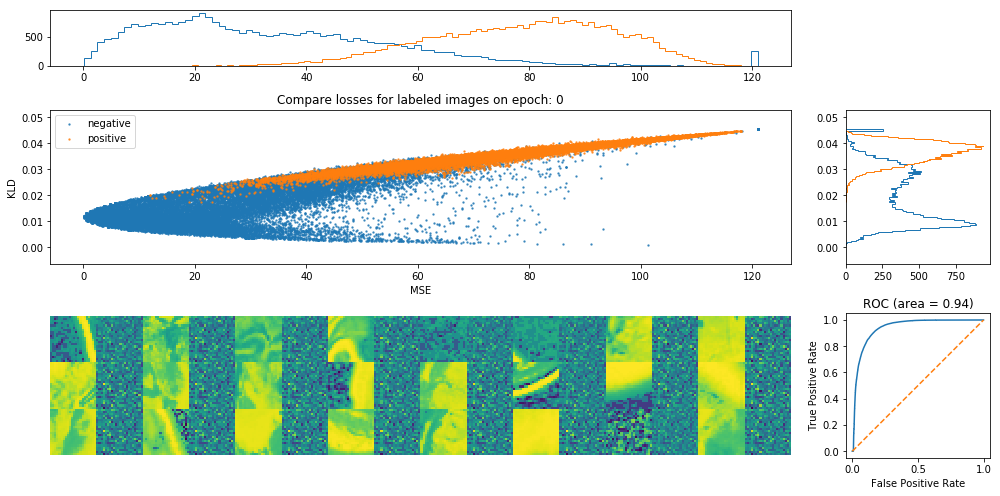

Epoch: 1


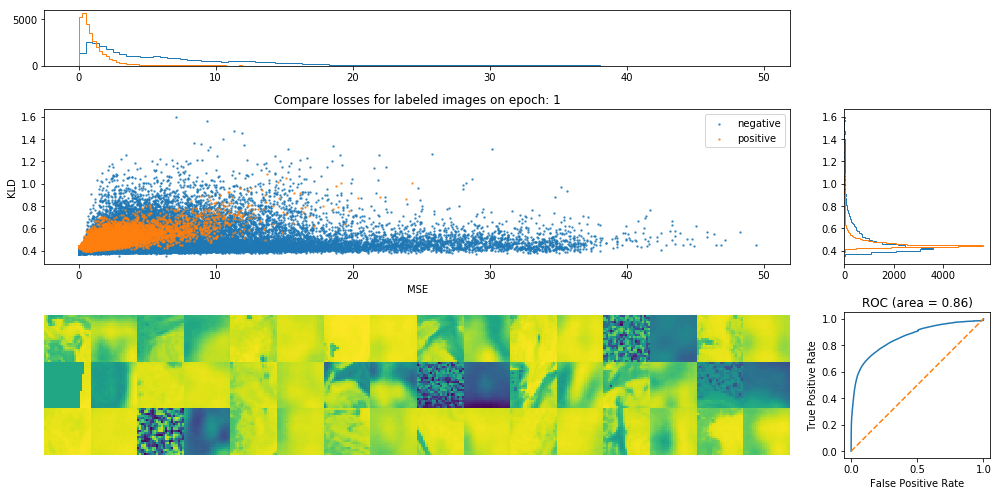

Epoch: 2


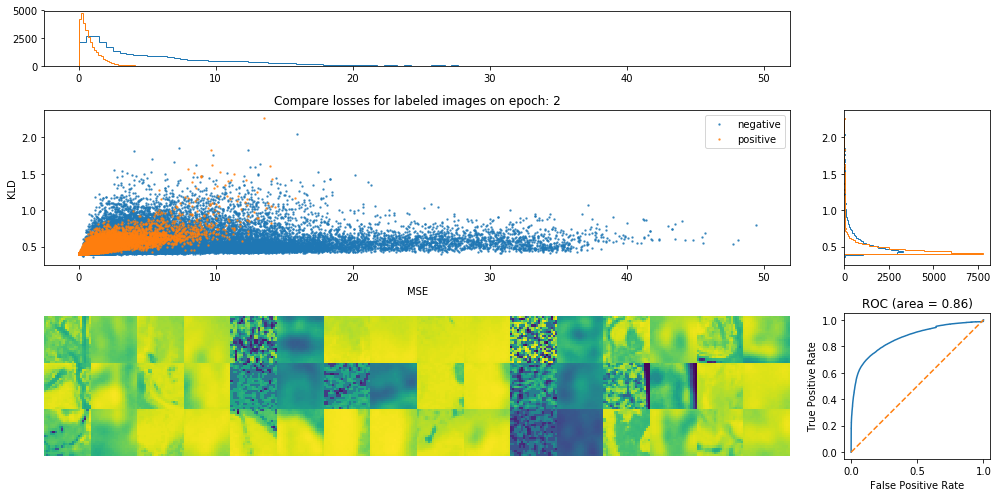

Epoch: 3


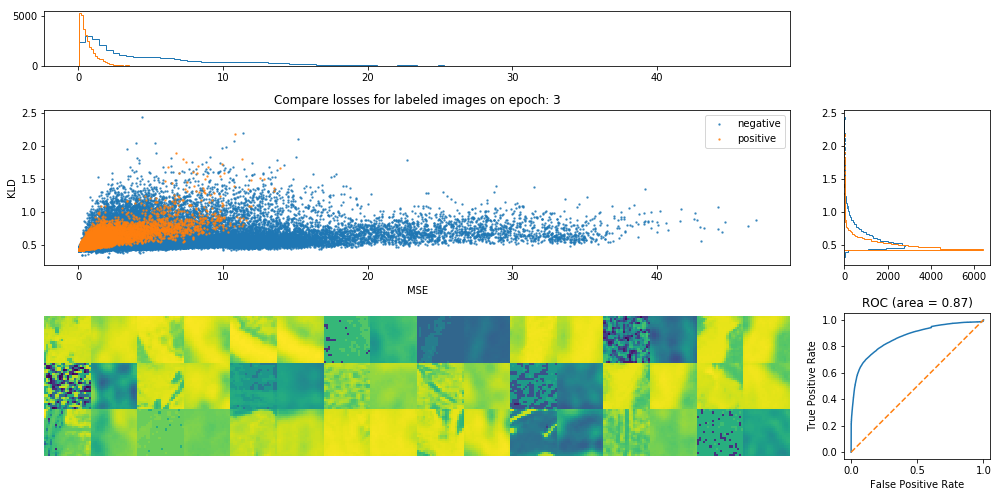

Epoch: 4


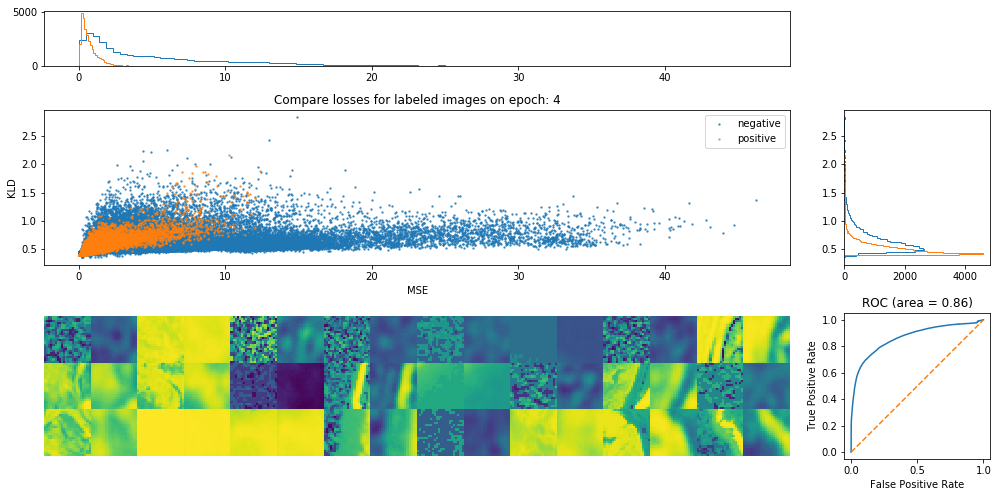

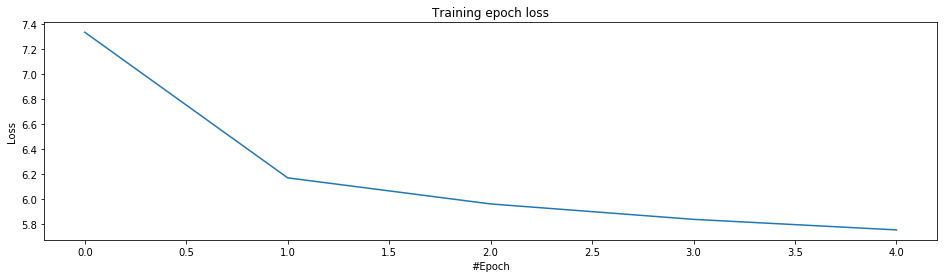

In [208]:
model.train()

test_epoch(0)
losses = []

for epoch in range(1, epochs + 1):
    train_loss = 0.
    
    for i, (data, _) in enumerate(train_loader):
        model.train()
        data = data.cuda()
        
        optimizer.zero_grad()

        recon_data, mu, logvar = model(data)

        loss, mse, kld = model.loss_function(data, recon_data, mu, logvar, extended=True)
        loss.backward()

        optimizer.step()
        
        train_loss += loss.item()
        
    losses.append(train_loss / len(train_loader))
    
    if epoch < 5 or epoch % 20 == 0:
        print(f'Epoch: {epoch}')
        test_epoch(epoch)
        if save_model:
            torch.save(model.state_dict(), 'checkpoints/model_{}_{}.pth'.format(name, epoch))
        
model.eval()

plt.figure(figsize=(16, 4))
plt.plot(losses)
plt.title('Training epoch loss')
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

In [209]:
predictions, targets = [], []

with torch.no_grad():
    for (images, labels) in tqdm(test_loader):
        images, labels = images.cuda(), labels.cuda()
        
        recon_data, mu, logvar = model(images)
        _, mse, kld = model.loss_function(images, recon_data, mu, logvar, extended=True)
        
        predictions.extend((mse + kld).squeeze().cpu().tolist())
        targets.extend(labels.cpu().tolist())

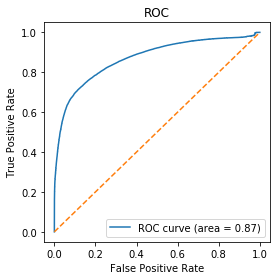

In [210]:
plt.figure(figsize=(4, 4))

fpr, tpr, thresholds = roc_curve(targets, predictions, pos_label=0)

area = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(area))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [225]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [212]:
optimal_idx = len(tpr[fpr <= 0.01])
optimal_threshold = thresholds[optimal_idx]

In [220]:
class ImageDataset(Dataset):
    def __init__(self, image, mask, patch_size=22, normalization=None):
        image_size, _, _ = image.shape
        size = image_size + patch_size - 1
        offset = patch_size // 2
        
        extended_image = np.zeros((size, size, 3))
        extended_image[offset: offset + image_size, offset: offset + image_size] = image
        
        if normalization:
            extended_image = normalization(extended_image[None])[0]
        
        extended_mask = np.zeros((size, size, 1))
        extended_mask[offset: offset + image_size, offset: offset + image_size] = mask
        
        self.image = extended_image
        self.mask = extended_mask
        
        self.patch_size = patch_size
        
        self.image_size, _, _ = self.image.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.patches_per_image
    
    def __getitem__(self, idx):                
        y = idx // self.patches_per_side
        x = idx % self.patches_per_side
        
        patch = self.image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1)
        label = self.mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0)) // 255
        
        return (patch, label)

In [214]:
indices = [i for i in range(len(medical_loader.test_masks)) if medical_loader.test_masks[i].sum() > 0]

In [235]:
optimal_threshold = 1.5

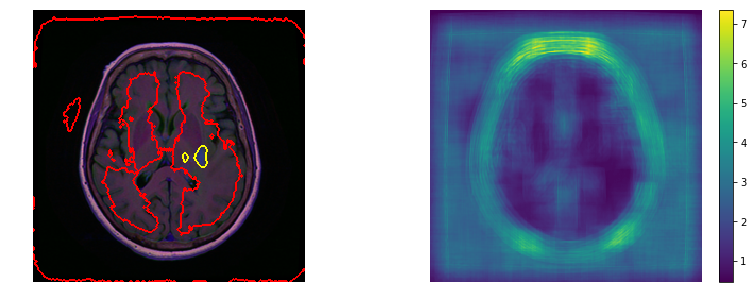

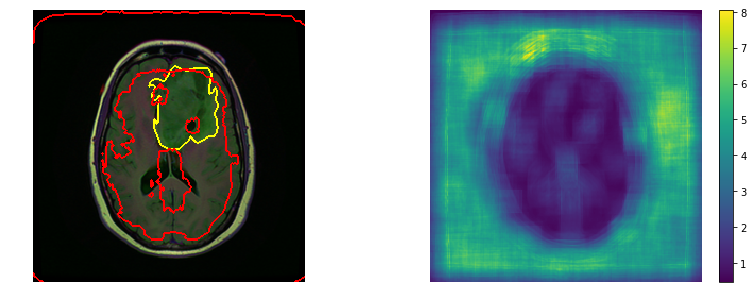

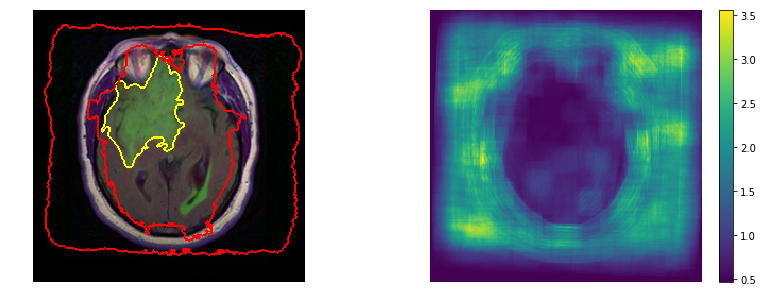

In [236]:
for idx in np.random.choice(indices, 3, replace=False):
    image = medical_loader.test_images[idx]
    mask = medical_loader.test_masks[idx]
    
    image_loader = DataLoader(ImageDataset(image, mask, 22, normalization), batch_size=128, num_workers=8)
    
    predicted_mask = []

    with torch.no_grad():
        for (images, labels) in image_loader:
            images, labels = images.cuda().float(), labels.cuda()

            recon_data, mu, logvar = model(images)
            _, mse, kld = model.loss_function(images, recon_data, mu, logvar, extended=True)
            
            predicted = (mse + kld).squeeze().cpu()
            predicted_mask.extend(predicted.tolist())
            
    predicted_mask = np.array(predicted_mask).reshape(256, 256)
    recon_mask = (predicted_mask < optimal_threshold) * 1.
    
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    masked_image = mark_boundaries(image, mask.squeeze(), mode='thick')
    plt.imshow(mark_boundaries(masked_image, recon_mask, color=(1, 0, 0), mode='thick'))
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(predicted_mask)
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [141]:
with h5py.File('/pio/lscratch/1/i279076/Medical/medical_v2.h5', 'r') as f:
    medical_images = f['test/images'][...]
    medical_masks = f['test/masks'][...]
    medical_patients = f['test/patients'][...]
    
#     medical_images = np.hstack([f['test/images'], f['train/images']])[...]
#     mdeical_masks = np.hstack([f['test/masks'], f['train/masks']])[...]
#     medical_patients = np.hstack([f['test/patients'], f['train/patients']])[...]

In [237]:
processed_images = []

for patient in tqdm(np.random.choice(np.unique(medical_patients), 5, replace=False)):
# for patient in tqdm(np.unique(medical_patients)):
    patient_images, patient_masks = medical_images[medical_patients == patient], medical_masks[medical_patients == patient]
    
    for i in tnrange(len(patient_masks), leave=False, desc=f'patient no. {patient}'):
        image, mask = patient_images[i], patient_masks[i]
        image_loader = DataLoader(ImageDataset(image, mask, 22, normalization), batch_size=512, num_workers=8)
        predicted_mask = []

        with torch.no_grad():
            for (data, labels) in image_loader:
                data, labels = data.cuda().float(), labels.cuda()

                recon_data, mu, logvar = model(data)
                _, mse, kld = model.loss_function(data, recon_data, mu, logvar, extended=True)

                predicted = (mse + kld).squeeze().cpu()
                predicted_mask.extend(predicted.tolist())

        predicted_mask = np.array(predicted_mask).reshape(256, 256)
        mask = mask.squeeze()

        processed_images.append((image, mask, predicted_mask, patient))

In [238]:
filtered_images = [(image, mask, recon_mask) for image, mask, recon_mask, _ in processed_images if mask.sum() > 0]

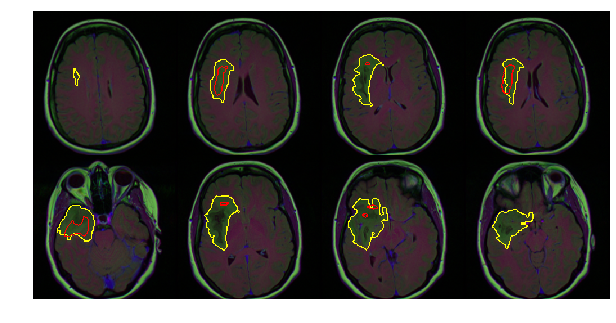

In [264]:
plt.figure(figsize=(8, 4))

for i, (image, mask, predicted_mask) in enumerate(filtered_images[:8], 1):    
    plt.subplot(2, 4, i)
    
    recon_mask = (predicted_mask < optimal_threshold) * 1.
    
    masked_image = mark_boundaries(image, mask, mode='thick')
    plt.imshow(mark_boundaries(masked_image, recon_mask, color=(1, 0, 0), mode='thick'))
    plt.axis('off')

plt.subplots_adjust(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.)
plt.show()

In [265]:
cm = np.zeros((2, 2))

for image, mask, predicted_mask, _ in processed_images:
    recon_mask = (predicted_mask < optimal_threshold).astype(int)
    
    cm[min(mask.sum(), 1), min(recon_mask.sum(), 1)] += 1

[[46. 92.]
 [ 6. 58.]]


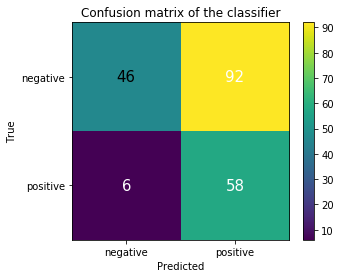

In [266]:
labels = ['negative', 'positive']
print(cm)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()

for x, y, amount, c in zip([0, 1, 0, 1], [0, 0, 1, 1], cm.flatten(), ['black', 'w', 'w', 'w']):
    plt.text(x, y, int(amount), color=c, fontsize=15, ha='center', va='center')

plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [263]:
optimal_threshold = 0.6

In [267]:
from collections import Counter

common_stats = Counter()
sum_stats = Counter()

for image, mask, predicted_mask, patient in processed_images:
    recon_mask = (predicted_mask < optimal_threshold).astype(int)
    common_mask = np.logical_and(mask, recon_mask) * 1.0
    
    common_stats[patient] += common_mask.sum()
    sum_stats[patient] += mask.sum() + recon_mask.sum()

dsc_stats = []
for patient in sum_stats.keys():
    dsc = 2 * common_stats[patient] / sum_stats[patient]
    dsc_stats.append(dsc)

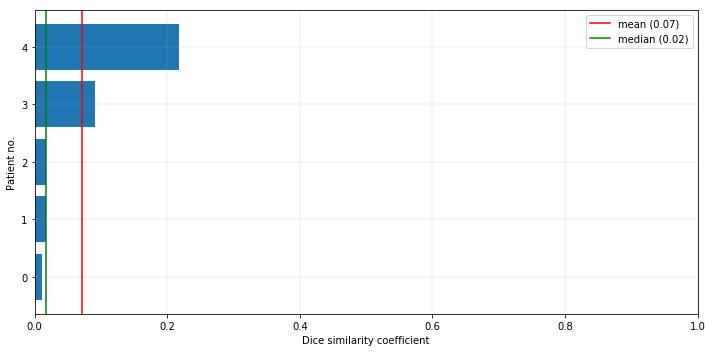

In [268]:
plt.figure(figsize=(10, 5))

plt.barh(range(len(dsc_stats)), sorted(dsc_stats), height=.8)
plt.grid(True, lw=0.2)

plt.axvline(np.mean(dsc_stats), c='r', label='mean ({:.2f})'.format(np.mean(dsc_stats)))
plt.axvline(np.median(dsc_stats), c='g', label='median ({:.2f})'.format(np.median(dsc_stats)))

plt.xlim(0, 1.)
plt.xlabel('Dice similarity coefficient')
plt.ylabel('Patient no.')
# plt.title()
plt.legend()

plt.tight_layout()
plt.show()

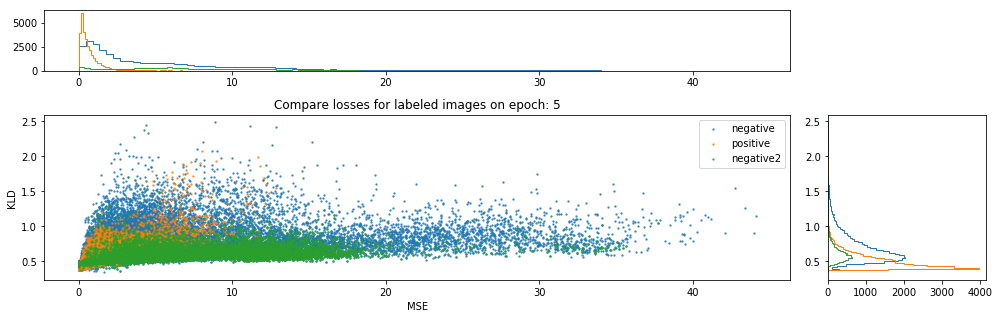

In [286]:
model.eval()

samples = len(test_loader.sampler)
X, Y, Z = np.zeros((2, samples)), np.zeros(samples), np.zeros(samples)

with torch.no_grad():
    for i, (data, labels) in enumerate(test_loader):
        data = data.cuda()

        recon_data, mu, logvar = model(data)
        _, mse, kld = model.loss_function(data, recon_data, mu, logvar, extended=True)

        X[:, i * batch_size : i * batch_size + len(data)] = torch.stack([mse, kld]).cpu()
        Y[i * batch_size : i * batch_size + len(data)] = labels
        Z[i * batch_size : i * batch_size + len(data)] = data.view(-1, 22 * 22 * 3).sum(1)

fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(5, 5)

ax_main = plt.subplot(gs[1:3, :4])
ax_xDist = plt.subplot(gs[0, :4], sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 4], sharey=ax_main)

for i, label in [(0, 'negative'), (1, 'positive')]:
    indices = (Y == i).nonzero()
    x, y = X[:, indices].squeeze()
    ax_main.scatter(x, y, s=2, alpha=0.7, label=label)
    ax_xDist.hist(x, bins=100, histtype='step')
    ax_yDist.hist(y, bins=100, orientation='horizontal', histtype='step')
    
for i, label in [(0, 'negative2')]:
    indices = (np.logical_and(Y == i, Z < 700)).nonzero()
    x, y = X[:, indices].squeeze()
    ax_main.scatter(x, y, s=2, alpha=0.7, label=label)
    ax_xDist.hist(x, bins=100, histtype='step')
    ax_yDist.hist(y, bins=100, orientation='horizontal', histtype='step')

ax_main.set(xlabel="MSE", ylabel="KLD", title=f'Compare losses for labeled images on epoch: {epoch}')
ax_main.legend()

plt.tight_layout()
plt.show()